<a href="https://colab.research.google.com/github/mgupta325/tensorflow_classification/blob/master/NLP_translation_frenchtoeng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [0]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [0]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [28]:
!wget http://www.manythings.org/anki/fra-eng.zip -O /content/fra11

--2020-05-07 13:05:31--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5982778 (5.7M) [application/zip]
Saving to: ‘/content/fra11’

/content/fra11      100%[===================>]   5.71M  10.1MB/s    in 0.6s    

2020-05-07 13:05:31 (10.1 MB/s) - ‘/content/fra11’ saved [5982778/5982778]



In [29]:
!ls

_about.txt  fra11  fra.txt  model.h1.7_may  sample_data


In [30]:
!unzip  fra11 

Archive:  fra11
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: _about.txt              
replace fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fra.txt                 


In [0]:
data = read_text("fra.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
deu_eng = deu_eng[:40000,0:2]
deu_eng


In [0]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

In [0]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

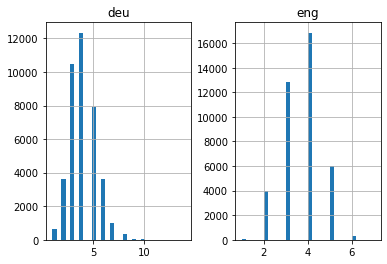

In [34]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [35]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare French tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('French Vocabulary Size: %d' % deu_vocab_size)


English Vocabulary Size: 5256
French Vocabulary Size: 12138


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [40]:
filename = 'model.h1.7_may'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25600 samples, validate on 6400 samples
Epoch 1/30
25600/25600 [==============================] - 4s 165us/step - loss: 3.5096 - val_loss: 2.8441

Epoch 00001: val_loss improved from inf to 2.84411, saving model to model.h1.7_may
Epoch 2/30
25600/25600 [==============================] - 4s 140us/step - loss: 2.7707 - val_loss: 2.7575

Epoch 00002: val_loss improved from 2.84411 to 2.75755, saving model to model.h1.7_may
Epoch 3/30
25600/25600 [==============================] - 4s 142us/step - loss: 2.6675 - val_loss: 2.6532

Epoch 00003: val_loss improved from 2.75755 to 2.65315, saving model to model.h1.7_may
Epoch 4/30
25600/25600 [==============================] - 4s 142us/step - loss: 2.5425 - val_loss: 2.5737

Epoch 00004: val_loss improved from 2.65315 to 2.57368, saving model to model.h1.7_may
Epoch 5/30
25600/25600 [==============================] - 4s 144us/step - loss: 2.4062 - val_loss: 2.4217

Epoch 00005: val_loss improved from 2.57368 to 2.42171, saving model to 

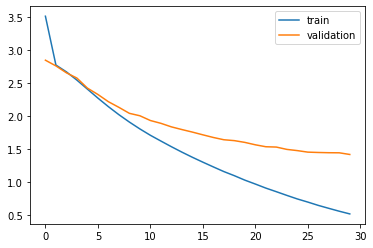

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [42]:
model = load_model('model.h1.7_may')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [46]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
3057,im impatient,im surprised
3189,what do they need,what do you need
2523,its too hard for me,its too for far
317,youre very timid,youre very timid
1559,i didnt volunteer,i didnt no a
5810,tom is still angry,tom is still angry
3763,its dirt cheap,thats is
3337,the maid made my bed,the dog is my bed
6976,i bought an old lamp,i had a mistake
4737,we cant go,we cant go there
